<span style="font-size:110%; text-align:left;"><b><a href="../index.html">2. Plane Waves</a> > <a href="./index.html">3. Optical Modulation</a></b></span>
<br/><br/>
<span style="font-size:200%; text-align:left;"><b>Optical beat</b></span>
<br/><br/>
<span style="font-size:110%; text-align:left;">Author: Daniel Töyrä </span>

<img src="files/optical_beat.svg" style="width: 900px;" align="center"/>

# Table of Contents
 <p><div class="lev1"><a href="#1.-Introduction">1. Introduction</a></div><div class="lev1"><a href="#2.-Optical-beat">2. Optical beat</a></div><div class="lev2"><a href="#2.1.-What-is-an-optical-beat">2.1. What is an optical beat</a></div><div class="lev2"><a href="#2.2.-Example-code-visualising-an-optical-beat">2.2. Example code visualising an optical beat</a></div><div class="lev2"><a href="#2.3.-Simulation-example">2.3. Simulation example</a></div><div class="lev1"><a href="#3.-Tasks">3. Tasks</a></div><div class="lev2"><a href="#3.1.-Detecting-beat-power">3.1. Detecting beat power</a></div><div class="lev1"><a href="#4.-Tasks-with-answers">4. Tasks with answers</a></div><div class="lev2"><a href="#4.1.-Detecting-beat-power">4.1. Detecting beat power</a></div><div class="lev1"><a href="#5.-Summary">5. Summary</a></div>

# 1. Introduction

Beat signals can show up in the power of optical fields consisting of two or more frequency components. This effect is of big importance since we it provides a way of converting phase modulation, which cannot be detected by a photo diode, into amplitude modulation which we can detect. This is utilised in the readout of gravitational wave detectors.

** Recommended notebooks before you start:**

We recommend that you have looked through introductory notebooks that you find in the folder [01_Introduction](../../01_Introduction/index.html) before you start this one, or that you have basic experience of IPython/Jupyter Notebooks, PyKat, and Finesse. The link above only works if you started IPython/Jupyter Notebook in the top directory of this course.

**Reading material and references:**

[1] [A. Freise, K. Strain, D. Brown, and C. Bond, "Interferometer Techniques for Gravitational-Wave Detection", *Living Reviews in Relativity* **13**, 1 (2010)](http://arxiv.org/pdf/0909.3661v3). - Living review article (more like a book) on laser interferometry in the frequency domain for detecting gravitational waves, and FINESSE.

[2] [A. Freise, D. Brown, and C. Bond, "Finesse, Frequency domain INterferomEter Simulation SoftwarE"](http://kvasir.sr.bham.ac.uk/redmine/attachments/download/131/Finesse_2.0_manual.pdf). - FINESSE-manual

[3] [FINESSE syntax reference](http://www.gwoptics.org/finesse/reference/) - Useful online syntax reference for FINESSE. Also available in the Finesse manual [2], but this online version is updated more frequently.

**After this session you will...**

* have seen that we can extract the relative phase information between to frequency components making up a laser field by using a `pd1` detector in FINESSE.
* have showed that we also can extract the amplitude of a very weak field that is beating against a much bigger one.
* be able to create a FINESSE model investigating a laser field consisting of two frequency components.

# 2. Optical beat

Importing PyKat and other Python packages that we need, and setting up how to display figures.

In [1]:
import numpy as np                         # Importing numpy
import matplotlib                          # For plotting
import matplotlib.pyplot as plt                   
from pykat import finesse                  # Importing the pykat.finesse package
from pykat.commands import *               # Importing all packages in pykat.commands
from IPython.display import display, HTML  # Allows us to display HTML

# Telling the notebook to make plots inline.
%matplotlib inline      
# Initialises the PyKat plotting tool. Change the dpi 
# value to adjust size of figures on your screen.
pykat.init_pykat_plotting(dpi=90)          

                                              ..-
    PyKat 1.1.349         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



## 2.1. What is an optical beat

Optical beat signals are created when the optical field consists of more than one frequency component. Lets look at the simplest case of just two frequency components: at some arbitrary point in space we have an optical field given by

\begin{align}
E(t) = a_c \mathrm{e}^{i\omega_c t} + a_1 \mathrm{e}^{i\omega_1 t}.
\end{align}

Here, the subscript $c$ stands for carrier and the subscript $1$ indicates a sideband. We want to distinguish these as for a gravitational wave detector, the carrier frequency is around 282 THz ($\lambda = 1064$ nm) while an upper sideband frequency preferably can be written as $\omega_1 = \omega_c + \omega_s$, where $\omega_s$ is somewhere between $10\times 2\pi $ rad/s and $10^9$ rad/s. A photo diode can only resolve power fluctuations up to around 100 MHz, thus what we will measure is the power averaged over some period of time. As we use units where the amplitude of the light field is expressed in $\sqrt{\mathrm{W}}$, the power averaged over the period time of the carrier is given by

\begin{align}
\bar{P}(t)= \big|E(t)\big|^2 &= \big|a_c\big|^2 + \big|a_1\big|^2 + a_c a_1^* \mathrm{e}^{-i\omega_s t} + a_c^* a_1 \mathrm{e}^{i\omega_s t} \\
                      &= \big|a_c\big|^2 + \big|a_1\big|^2 + 2\mathcal{Re} \big(a_c^* a_1 \mathrm{e}^{i\omega_s t} \big).
\end{align}

We end up with a DC part, and an AC part of frequency $\omega_s = \big| \omega_c - \omega_1 \big|$. We say that the two frequency components beat against each other to create this **beat signal**. Usually, it is the amplitude, frequency, and phase of the sideband are the information we are interested in extracting. However, the sideband amplitude is normally tiny compared to the carrier amplitude, so in the DC part it is hard to detect its magnitude. However, the time dependent term is proportional to the sideband amplitude, so if we can separate the DC and AC part somehow (demodulation and low pass filter) we could extract this information. 

## 2.2. Example code visualising an optical beat

In the example below we look at a laser field containing two frequency components, and how the power of this field looks like.

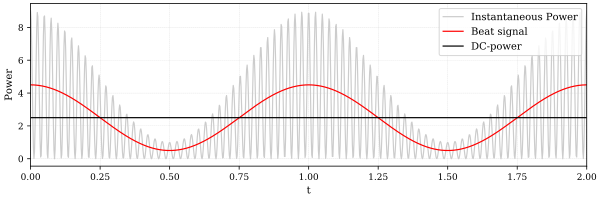

In [2]:
## Code for showing an optical beat ##

# Parameters
# -------------------------------------
# Time array [s]
t = np.linspace(0,2,1000)
# Frequencies [Hz]
f1 = 20
f2 = 21
# Phases
phi1 = 0
phi2 = 0
# Amplitudes
a1 = 2
a2 = 1

# Computing the fields
# -------------------------------------
# The two fields
E1 = a1*np.cos(2*np.pi*f1*t + phi1)
E2 = a2*np.cos(2*np.pi*f2*t + phi2)
# The total field
E = E1+E2
# The total power at the photo diode
P = E**2
# The obtical beat signal
beat = a1*a2*np.cos((f2-f1)*2*np.pi*t)
# DC power
dc = (a1**2 + a2**2)/2

# Plotting
# -------------------------------------
fig = plt.figure(figsize=(10,3))
ax = plt.subplot(111)
ax.plot(t,P,'0.8',label='Instantaneous Power')
ax.plot(t,dc+beat,'r', label='Beat signal')
ax.plot([t[0],t[-1]],[dc,dc],'k',label='DC-power')
ax.set_xlabel('t')
ax.set_ylabel('Power')
ax.legend(loc=1, fontsize=10)
plt.show(fig)

**Figure.** The figure shows the instantaneous power (gray), the beat signal measurable with a photo diode (red), and the DC power (black) that we obtain when using a low pass filter after the photo diode. To generate the figure, we have used $E(t) = a_c \cos(\omega_c t) + a_1 \cos(\omega_1 t)$, with $a_c = 2~\sqrt{\mathrm{W}}$, $a_1 = 1~\sqrt{\mathrm{W}}$, $f_c = 20$ Hz, and $f_1 = 21$ Hz.

## 2.3. Simulation example

We use two lasers with slightly different frequencies, one with the default frequency of $f_1 = 282$ THz and one with an offset of $\Delta f = 10$ kHz, thus $f_2 = f_1 + \Delta f$. We combine these two laser fields by using a beam splitter as shown in the figure below, and we will detect the combined laser field by using a couple of different detectors. In this example we will show that by: 

* detecting the combined power with a photo diode 
* then demodulating the photo diode output with the demodulation frequency equal to the frequency difference $\Delta f$ 
* then low pass filtering the demodulation output

we can extract the relative phase between the two frequency components. We will not explain demodulation at this stage, but if you want to learn about it directly, see [01_Demodulation.ipynb](../04_Demodulation_and_transfer_function/01_Demodulation.ipynb). The scope here is to show that the optical beat between two signals can give us information that we could not extract without it. The three bullet points above is almost exactly what the FINESSE component `pd1` does.

<img src="optical_beat_setup.svg" style="width: 300px;"/>

The base FINESSE model we will use for this session:

In [3]:
basekat = finesse.kat()    # Initialising FINESSE
basekat.verbose = False    # Keep quiet

# FINESSE code
code = '''
const freq 10k             # creating a constant for the frequency offset

l laser1 1 0 n1            # laser with P=1W at the default frequency
s s1 1n n1 n2              # space of 1nm length

l laser2 0.1 $freq n3      # a second laser with f=10kHz frequency offset
s s2 1n n3 n4              # another space of 1nm length

bs bs1 0.5 0.5 0 0 n2 n5 dump n4   # 50:50 beam splitter
s s3 1n n5 n6                      # another space of 1nm length
'''
basekat.parse(code)

Adding detectors and simulation instructions:

In [4]:
# Copying basekat
kat = deepcopy(basekat)

# FINESSE code
code = '''
const freq 10k             
## Detectors ##
ad a1 0 n6                        # amplitude detector, default frequency
ad a2 $freq n6                    # amplitude detector, 10 kHz offset
pd dc n6                          # photo didoe, measuring DC-power
pd1 ac $freq n6                   # photo diode + demodulation at 10kHz + 
                                  # + low pass filter

## Simulation instructions ##
xaxis laser2 phi lin 0 180 200     # Sweeping phase of beam from laser2
yaxis abs:deg                      # Returns complex representation of detector outputs
'''

# Running the simulation
kat.parse(code)
out = kat.run()

Plotting results:

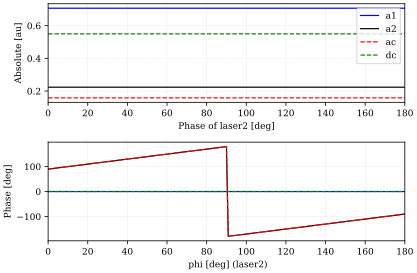

In [5]:
# Setting 
styles={'a1':'b-','a2':'k-','dc':'g--','ac':'r--'}

fig = out.plot(styles = styles, 
               xlabel='Phase of laser2 [deg]',
               loc=1)

In the upper figure we see that all detector outputs are independent on the phase of the second laser field. Note that the y-axis shows both amplitude and power at the same time, since `a1` and `a2` are amplitudes, while `ac` and `dc` are powers.

The lower figure shows that as we sweep the phase of the second laser, the phase of the `pd1` detector (photo diode + demodulation + low pass filter) called `ac` follows the non-realistic amplitude detector that magically detects the amplitude and phase of the laser field originating from `laser2`. Thus, by using demodulation we can extract the phase information. It is important to understand that it is the phase relative to `laser1` that we are able to detect. It is even more important to understand that without at least two frequency components, there is no way of extracting the phase information. So optical beats are very important.

# 3. Tasks

## 3.1. Detecting beat power

Modify the example below, and show that we can extract the amplitude from `laser2`, even for very small amplitudes where it is negligible compared to `laser1`. Consider the amplitude of `laser1` as known.

**Answer:**

# 4. Tasks with answers

## 4.1. Detecting beat power

Modify the example below, and show that we can extract the amplitude from `laser2`, even for very small amplitudes where it is negligible compared to `laser1`. Consider the amplitude of `laser1` as known.

**Answer:**

What we need to do here is

* change the `xaxis` command to sweep the power of `laser2`.
* change the `yaxis` command to `abs`, i.e., we only want the amplitude, not the phase information.

We also make both axes logarithmic since we want to sweep many orders of magnitude.

In [8]:
kat2 = deepcopy(basekat)

code = '''
const freq 10k      
## Detectors ##
ad a1 0 n6                        # amplitude detector at f=0Hz
ad a2 $freq n6                    # amplitude detector at f=10kHz
pd dc n6                          # simple photo detector
pd1 ac $freq n6                   # photo didoe + demodulation at 10kHz + 
                                  # + low pass filter

## Simulation instructions ##
xaxis laser2 P log 1p 1 100       # sweeping laser2 power from 1 pW to 1W (log scale)
yaxis log abs                     # plotting magnitude of detector outputs (log scale)

## Recreating amplitude of laser2 from measured data ##
set pow dc abs                    # making output of dc available as variable 
                                  # with name pow.
set ac1 ac abs                    # making output of ac avaiblable as variable 
                                  # with name ac1.
func E2 = $ac1/sqrt($pow+1E-21)   # Recreating amplitude of laser2. 1E-21 is used 
                                  # in denominator to avoid division by zero.
'''

# Parsing and running the simulation
kat2.parse(code)
out2 = kat2.run()

Plotting the results:

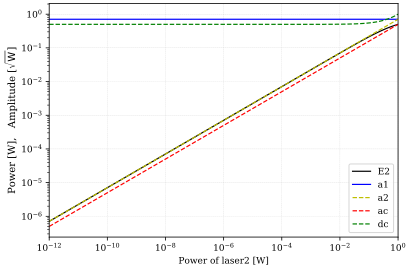

In [9]:
# Setting plotting style for the detectors
style = {'a1':'b-','a2':'y--','dc':'g--','ac':'r--','E2':'k-'}
fig2 = out2.plot(styles = style, 
                 xlabel='Power of laser2 [W]', 
                 ylabel='Power [W],   Amplitude [$\sqrt{\mathrm{W}}$]',
                 loc=4)

From the figure above we can see that the DC-power is effectively unaffected by the amplitude of `laser2` as long as it is significantly smaller than the amplitude of `laser1`. Since the trace `E2` perfectly matches trace `a2` for small `laser2` amplitudes, we can also conclude that we can recreate the amplitude of `laser2` by measuring the the DC power and the demodulation output as long as `laser2` is weak compared to `laser1`.

# 5. Summary

In this session we have:
* used two lasers and a beam splitter to combine two different laser fields and studied the optical beat this gives rise to.
* seen that the relative phase between the two fields can be determined by using the `pd1` detector in FINESSE, which corresponds to a photo diode, a demodulation, and a low pass filter.
* showed that the amplitude of a very weak field can be determined by using `pd1`, as long as we have a second stronger field to beat it against.

In the next session [Modulation by a Moving Mirror](04_Modulation_by_moving_mirror.html) we will learn how a moving mirror can produce modulated light.